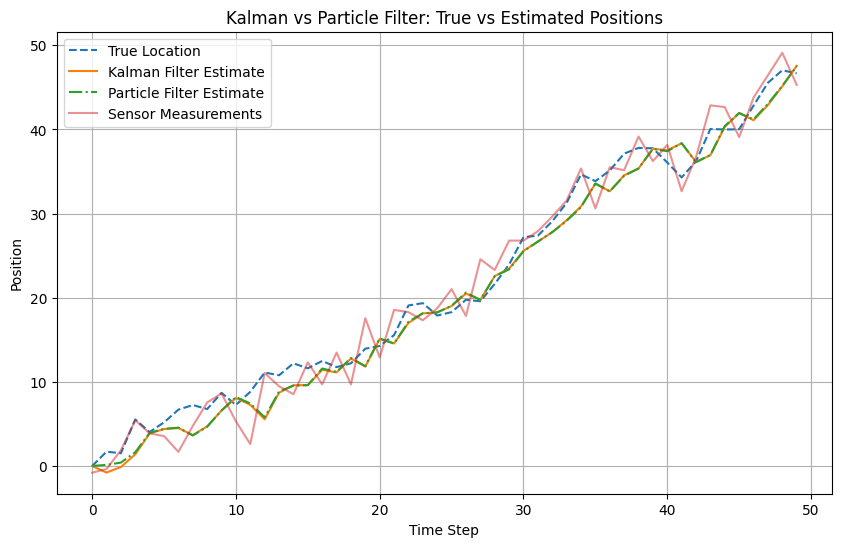

MSE - Kalman Filter: 4.15
MSE - Particle Filter: 3.92
MSE - Sensor Measurements: 4.85


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class Drone:
    def __init__(self, initial_position, movement, mov_variance, sensor_variance):
        self.position = initial_position
        self.movement = movement
        self.mov_variance = mov_variance
        self.sensor_variance = sensor_variance

    def get_true_position(self):
        return self.position

    def measure_and_move(self):
        current_position = self.position
        movement = np.random.normal(self.movement, np.sqrt(self.mov_variance))
        self.position += movement
        sensor_output = np.random.normal(current_position, np.sqrt(self.sensor_variance))
        return sensor_output

def predict(position, position_variance, movement, movement_variance):
    new_position = position + movement
    new_position_variance = position_variance + movement_variance
    return new_position, new_position_variance

def update(position, position_variance, measurement, measurement_variance):
    kalman_gain = position_variance / (position_variance + measurement_variance)
    new_position = position + kalman_gain * (measurement - position)
    new_position_variance = (1 - kalman_gain) * position_variance
    return new_position, new_position_variance

class ParticleFilter:
    def __init__(self, num_particles, init_position, mov_variance, sensor_variance):
        self.num_particles = num_particles
        self.particles = np.random.normal(init_position, np.sqrt(mov_variance), num_particles)
        self.weights = np.ones(num_particles) / num_particles
        self.mov_variance = mov_variance
        self.sensor_variance = sensor_variance

    def predict(self, movement):
        self.particles += np.random.normal(movement, np.sqrt(self.mov_variance), self.num_particles)

    def update(self, measurement):
        self.weights = np.exp(-0.5 * ((self.particles - measurement) ** 2) / self.sensor_variance)
        self.weights += 1e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(self.num_particles, self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        return np.mean(self.particles)

def main():
    N = 50  # Time steps
    num_particles = 1000
    init_position = 0
    init_uncertainty = 20**2
    movement = 1.0
    movement_variance = 2.0
    sensor_variance = 4.5

    # Kalman Filter variables
    position = init_position
    position_variance = init_uncertainty
    
    # Particle Filter initialization
    pf = ParticleFilter(num_particles, init_position, movement_variance, sensor_variance)
    
    drone = Drone(init_position, movement, movement_variance, sensor_variance)

    true_positions = []
    kl_estimates = []
    pf_estimates = []
    sensor_measurements = []

    for _ in range(N):
        true_positions.append(drone.get_true_position())
        kl_estimates.append(position)
        pf_estimates.append(pf.estimate())

        position, position_variance = predict(position, position_variance, movement, movement_variance)
        pf.predict(movement)

        measurement = drone.measure_and_move()
        sensor_measurements.append(measurement)

        position, position_variance = update(position, position_variance, measurement, sensor_variance)
        pf.update(measurement)
        pf.resample()
    
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions, label="True Location", linestyle="--")
    plt.plot(kl_estimates, label="Kalman Filter Estimate")
    plt.plot(pf_estimates, label="Particle Filter Estimate", linestyle="-." )
    plt.plot(sensor_measurements, label="Sensor Measurements", alpha=0.5)
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Kalman vs Particle Filter: True vs Estimated Positions")
    plt.legend()
    plt.grid()
    plt.show()

    mse_kf = mean_squared_error(true_positions, kl_estimates)
    mse_pf = mean_squared_error(true_positions, pf_estimates)
    mse_meas = mean_squared_error(true_positions, sensor_measurements)

    print(f"MSE - Kalman Filter: {mse_kf:.2f}")
    print(f"MSE - Particle Filter: {mse_pf:.2f}")
    print(f"MSE - Sensor Measurements: {mse_meas:.2f}")

if __name__ == "__main__":
    main()
